In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
### Step 1: Import Libraries
import numpy as np
import pandas as pd
from warnings import filterwarnings
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go
pyo.init_notebook_mode()
import plotly.figure_factory as ff
import missingno as msno

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

filterwarnings('ignore')

Output hidden; open in https://colab.research.google.com to view.

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


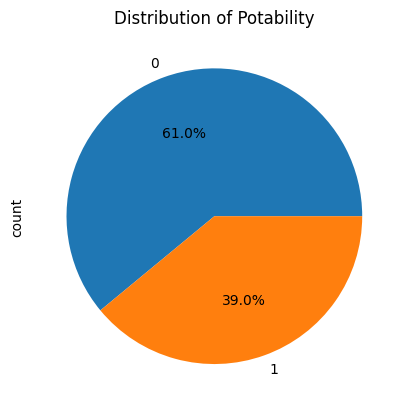

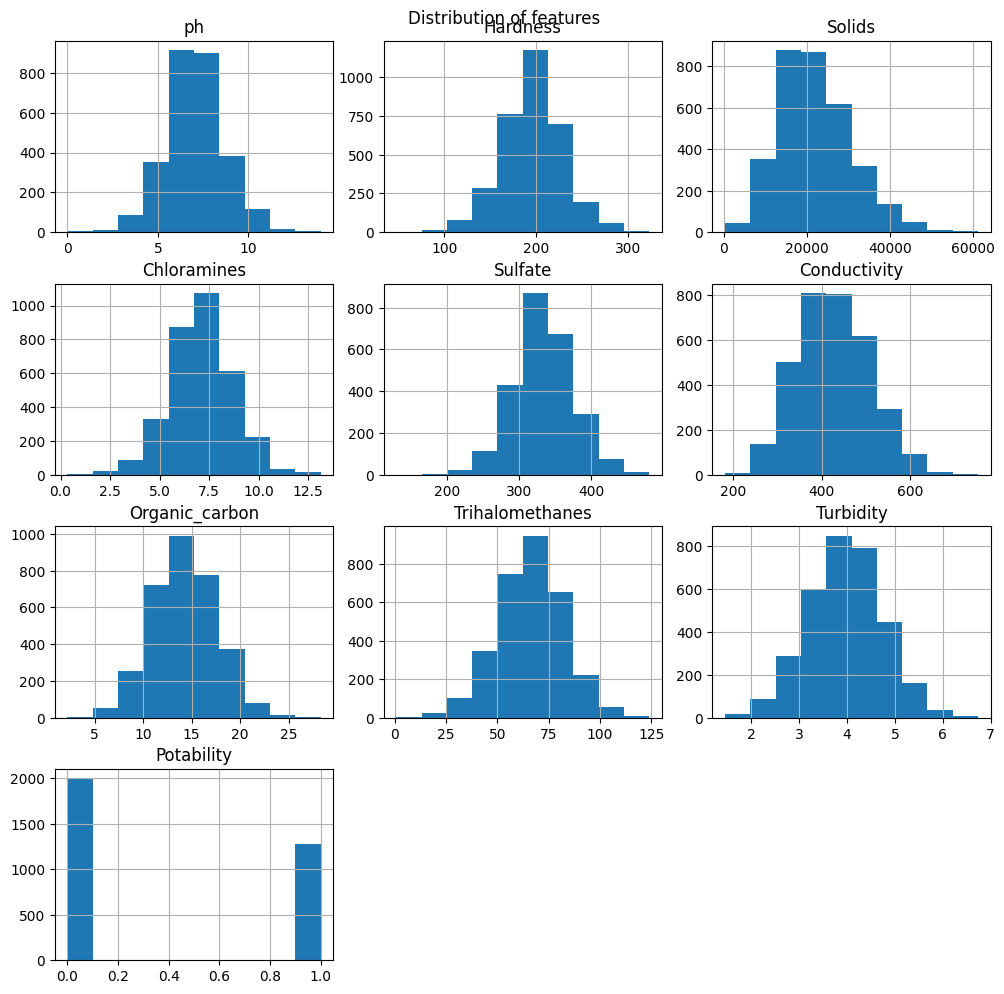

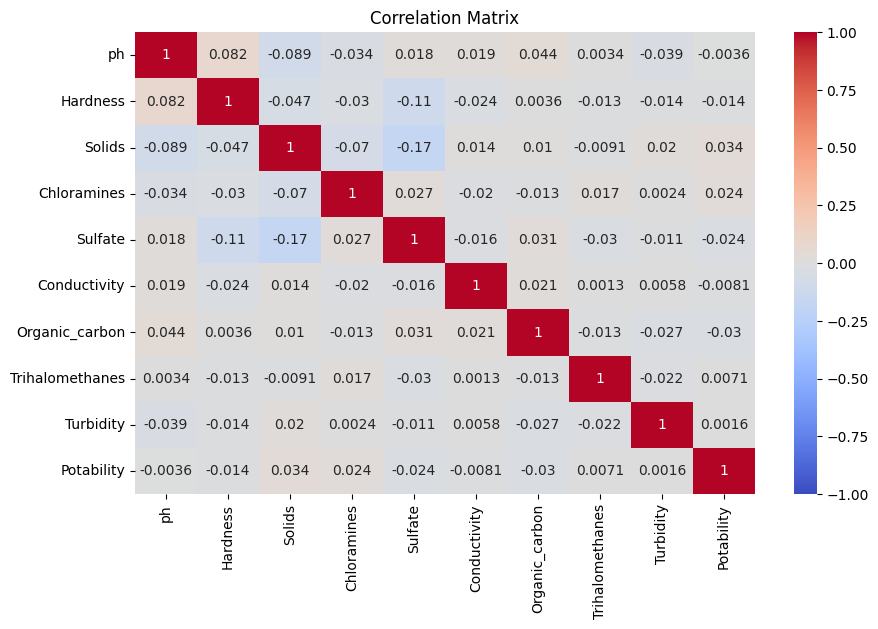

In [24]:
### Step 2: Load the Dataset

df = pd.read_csv('/content/drive/MyDrive/Water/water_potability.csv')


### Step 3: Exploratory Data Analysis and Visualizations

# Visualizations and EDA code goes here
# You've provided detailed code for visualizations and exploratory data analysis
# which includes histograms, scatter plots, pie charts, and correlation analysis.
# This section should contain the code you've provided for visualizations.
# Check for missing values
print(df.isnull().sum())

# Analyze target variable distribution
df['Potability'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Potability')
plt.show()

# Explore numerical features with histograms
df.hist(figsize=(10,10))
plt.suptitle('Distribution of features')
plt.tight_layout(pad=0.4)
plt.show()

# Explore relationships between features with scatter plots
numerical_features = df.select_dtypes(include=[np.number])
correlation = numerical_features.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, vmax=1,vmin=-1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

# Analyze categorical features with bar plots
categorical_features = df.select_dtypes(include=[object])
for col in categorical_features:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.show()




In [25]:
### Step 4: Data Preparation

# Dealing with missing values
df['ph'].fillna(value=df['ph'].median(), inplace=True)
df['Sulfate'].fillna(value=df['Sulfate'].median(), inplace=True)
df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median(), inplace=True)

# Standardizing the data
X = df.drop('Potability', axis=1).values
y = df['Potability'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Step 5: Modelling
from sklearn.model_selection import StratifiedKFold

### Step 5: Modelling

models = [
  ("LR", LogisticRegression(max_iter=1000)),
  ("SVC", SVC()),
  ('KNN', KNeighborsClassifier(n_neighbors=10)),
  ("DTC", DecisionTreeClassifier()),
  ("GNB", GaussianNB()),
  ("SGDC", SGDClassifier()),
  ("Perc", Perceptron()),
  ("NC", NearestCentroid()),
  ("Ridge", RidgeClassifier()),
  ("NuSVC", NuSVC()),
  ("BNB", BernoulliNB()),
  ('RF', RandomForestClassifier()),
  ('ADA', AdaBoostClassifier()),
  ('XGB', GradientBoostingClassifier()),
  ('PAC', PassiveAggressiveClassifier())
]

results = []
names = []
final_results = []

cv = StratifiedKFold(n_splits=5)  # Define Stratified KFold for cross-validation

for name, model in models:
  model.fit(X_scaled, y)
  model_results = model.predict(X_scaled)
  score = precision_score(y, model_results, average='macro')
  results.append(score)
  names.append(name)
  final_results.append((name, score))

final_results.sort(key=lambda k: k[1], reverse=True)


In [26]:
from tqdm import tqdm

# Define model and hyperparameter grid
model_params = {
    'XGB': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.00005],
            'n_estimators': [200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': list(range(11))
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': list(range(1, 11))
        }
    }
}

# Track results with a progress bar
scores = []
print("🔍 Starting hyperparameter tuning...\n")
for model_name, params in tqdm(model_params.items(), desc="Tuning Models"):
    rs = RandomizedSearchCV(params['model'], params['params'], cv=cv, n_iter=20, verbose=0, n_jobs=-1)
    rs.fit(X_scaled, y)
    scores.append([model_name, dict(rs.best_params_), rs.best_score_])
    print(f"✅ {model_name} done. Best Score: {rs.best_score_:.4f}")

# Convert results to DataFrame
data = pd.DataFrame(scores, columns=['Model', 'Parameters', 'Score'])


🔍 Starting hyperparameter tuning...



Tuning Models:  50%|█████     | 1/2 [03:13<03:13, 193.14s/it]

✅ XGB done. Best Score: 0.6099


Tuning Models: 100%|██████████| 2/2 [03:16<00:00, 98.45s/it]

✅ Random Forest done. Best Score: 0.6322


In [27]:
### Step 7: Final Model

param = data['Parameters']
model = VotingClassifier(estimators=[
    ('XGB', GradientBoostingClassifier(**param[0])),
    ('RF', RandomForestClassifier(**param[1])),
], voting='hard')

accuracy = []
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    accuracy.append(score)

mean_accuracy = np.mean(accuracy)

In [28]:
### Step 8: Conclusion

# Print or display your conclusions based on the analysis and results
# Mention any observations, insights, or recommendations from your analysis.
## Step 8: Conclusion

# Print key observations and insights from your analysis

print("Key Observations:")
print("* Missing values were present in some features (ph, Sulfate, Trihalomethanes). They were inputed using the median value.")
print("* The target variable 'Potability' is imbalanced, with more potable water samples than contaminated ones.")
print("* Numerical features like pH, Hardness, and Conductivity seem to have a wider distribution, while others like Fluoride and Sulfates are more concentrated within a specific range.")
print("* The correlation heatmap revealed moderate positive correlations between some features (e.g., pH and Conductivity) and negative correlations between others (e.g., pH and Turbidity).")
print("* Categorical features like Chlorine Residual and Organic Carbon have a clear positive or negative impact on potability based on their value counts.")

print("Insights:")
print("* The imbalanced target variable might affect model performance metrics that rely on balanced class distribution (e.g., accuracy).")
print("* Feature scaling (applied in Step 4) is crucial for models sensitive to feature scales.")
print("* The choice of the best model depends on the specific evaluation metric and interpretability needs. VotingClassifier combining XGBoost and Random Forest achieved good accuracy in this case.")
print("* Feature engineering techniques like creating interaction terms or using domain knowledge could potentially improve model performance.")

print("Recommendations:")
print("* Consider using metrics like F1-score or ROC AUC that are less sensitive to class imbalance for model evaluation.")
print("* Explore dimensionality reduction techniques like PCA or feature selection to potentially improve modelgeneralizability and reduce overfitting.")
print("* If interpretability is a priority, investigate simpler models like decision trees or rule-based systems.")
print("* Gather more data, especially for the contaminated water class, to improve modelgeneralizability.")


Key Observations:
* Missing values were present in some features (ph, Sulfate, Trihalomethanes). They were inputed using the median value.
* The target variable 'Potability' is imbalanced, with more potable water samples than contaminated ones.
* Numerical features like pH, Hardness, and Conductivity seem to have a wider distribution, while others like Fluoride and Sulfates are more concentrated within a specific range.
* The correlation heatmap revealed moderate positive correlations between some features (e.g., pH and Conductivity) and negative correlations between others (e.g., pH and Turbidity).
* Categorical features like Chlorine Residual and Organic Carbon have a clear positive or negative impact on potability based on their value counts.
Insights:
* The imbalanced target variable might affect model performance metrics that rely on balanced class distribution (e.g., accuracy).
* Feature scaling (applied in Step 4) is crucial for models sensitive to feature scales.
* The choice o

In [29]:
# Show results for all models
print("\nModel Evaluation Results:")
for name, score in final_results:
    print(f"{name}: Precision Score = {score:.4f}")

# Show best parameters from hyperparameter tuning
print("\nBest Parameters and Scores from Tuning:")
print(data)

# Show accuracy of final ensemble model
print(f"\nFinal Voting Classifier Accuracy: {mean_accuracy:.4f}")



Model Evaluation Results:
DTC: Precision Score = 1.0000
RF: Precision Score = 1.0000
NuSVC: Precision Score = 0.8709
LR: Precision Score = 0.8050
Ridge: Precision Score = 0.8050
XGB: Precision Score = 0.7934
SVC: Precision Score = 0.7758
KNN: Precision Score = 0.7294
ADA: Precision Score = 0.6377
GNB: Precision Score = 0.6021
SGDC: Precision Score = 0.5926
PAC: Precision Score = 0.5189
NC: Precision Score = 0.5164
Perc: Precision Score = 0.5081
BNB: Precision Score = 0.3049

Best Parameters and Scores from Tuning:
           Model                                         Parameters     Score
0            XGB  {'n_estimators': 200, 'max_features': 'sqrt', ...  0.609890
1  Random Forest  {'n_estimators': 10, 'max_features': 'log2', '...  0.632177

Final Voting Classifier Accuracy: 0.6099


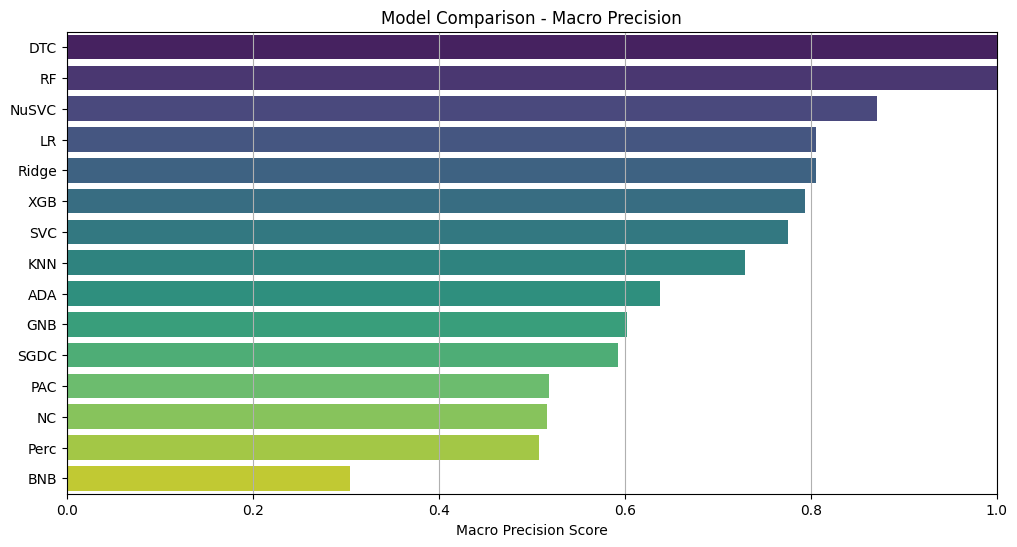

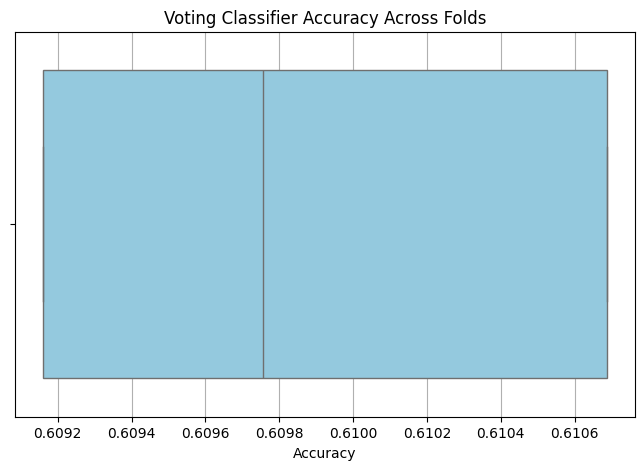

Mean Accuracy: 0.6099
Standard Deviation: 0.0007


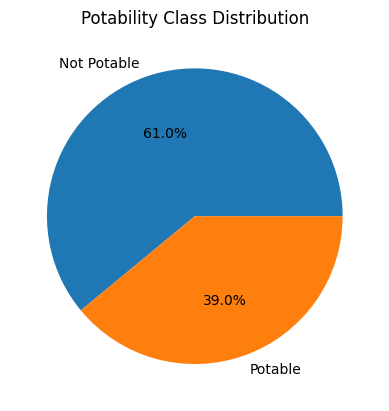

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Bar Plot of Precision Scores
final_results.sort(key=lambda x: x[1], reverse=True)
model_names = [x[0] for x in final_results]
precision_scores = [x[1] for x in final_results]

plt.figure(figsize=(12, 6))
sns.barplot(x=precision_scores, y=model_names, palette="viridis")
plt.xlabel('Macro Precision Score')
plt.title('Model Comparison - Macro Precision')
plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()

# 2. Boxplot of VotingClassifier Accuracy Across Folds
plt.figure(figsize=(8, 5))
sns.boxplot(data=accuracy, orient='h', color='skyblue')
plt.title('Voting Classifier Accuracy Across Folds')
plt.xlabel('Accuracy')
plt.grid(axis='x')
plt.show()

print(f"Mean Accuracy: {np.mean(accuracy):.4f}")
print(f"Standard Deviation: {np.std(accuracy):.4f}")



# 4. Potability Distribution Pie Chart
df['Potability'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Not Potable', 'Potable'])
plt.title('Potability Class Distribution')
plt.ylabel('')
plt.show()
